In [1]:
# Import Libraries
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


device(type='cuda')

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

Phase 1: Data Collection and Preprocessing

In [5]:
# Load dataset
%cd /content/drive/MyDrive/[AI] Ngoc Quy/Bully
data = pd.read_csv('data/data.csv')
data = data.iloc[:, 1:]
print(data.info())
data.head()

/content/drive/MyDrive/[AI] Ngoc Quy/Bully
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11056 entries, 0 to 11055
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  11056 non-null  object
 1   label    11056 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 172.9+ KB
None


,content,label
0,Dừa lắm :)),0
1,Bấp bênh vl thế,1
2,Chắc cũng biết ko tồn tại đc bao lâu nữa nên c...,1
3,Thấy chán ad page này kiến thức thì nông cản c...,1
4,Giang Giang Đỗ Thị Ngọc Hà trend mới kìa kìa,0


<Axes: xlabel='label', ylabel='count'>

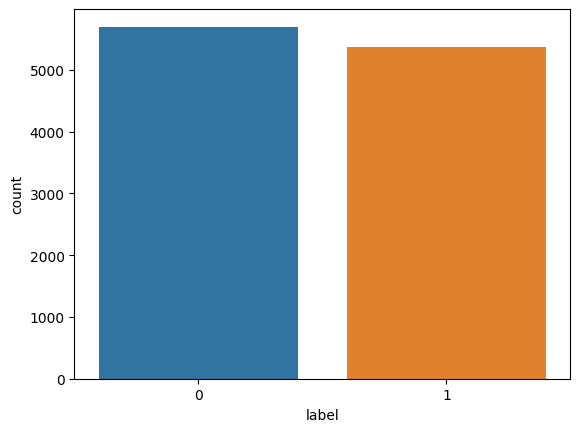

In [6]:
# Visualize the distribution of labels
sns.countplot(x='label', data=data)

In [7]:
# Create training dataset
train_df = data.iloc[:int(len(data)* 0.8)]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8844 entries, 0 to 8843
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  8844 non-null   object
 1   label    8844 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 138.3+ KB


In [8]:
# Create testing dataset
test_df = data.iloc[len(train_df):]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 8844 to 11055
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2212 non-null   object
 1   label    2212 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.7+ KB


Phase 2: Model Building and Training

In [9]:
# "StratifiedKFold" class
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold

In [10]:
# Load a tokenizer for the PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [11]:
class SentimentDataset(Dataset):
    # Initialization
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    # Length Method
    def __len__(self):
        return len(self.df)

    # Get Item Method
    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    # Get Input Data Method
    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['content']
        text = ' '.join(simple_preprocess(text))
        label = row['label']

        return text, label

Text(0.5, 9.444444444444438, 'Token Count')

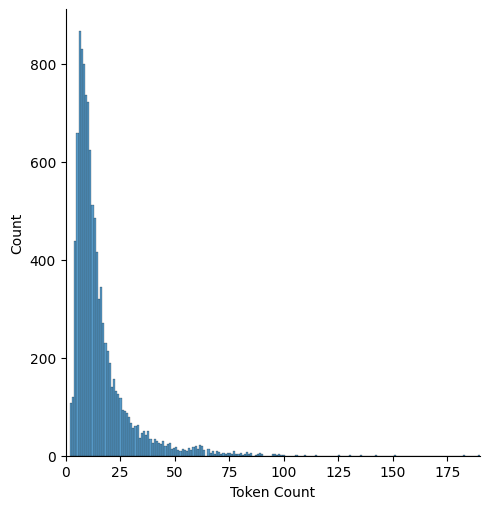

In [12]:
# Distribution of length of Sentence
all_data = train_df.content.tolist() + test_df.content.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [13]:
class SentimentClassifier(nn.Module):
    # Initialization
    def __init__(self, n_classes, device):
        super(SentimentClassifier, self).__init__()
        # Model Architecture
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)
        self.device = device  

    # Forward Method
    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False 
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [14]:
# "train" function
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

# "eval" function
def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [15]:
# "prepare_loaders" function
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [16]:
# Training and evaluation
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7, device = device).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch 1/6
------------------------------
Train Accuracy: 0.7304593639575973 Loss: 0.612429358451953
Valid Accuracy: 0.8518937252685133 Loss: 0.3899094953059076
Epoch 2/6
------------------------------
Train Accuracy: 0.8824028268551237 Loss: 0.3081470961024476
Valid Accuracy: 0.8795929903900508 Loss: 0.34302725827506
Epoch 3/6
------------------------------
Train Accuracy: 0.9238162544169611 Loss: 0.22241001544440372
Valid Accuracy: 0.8688524590163934 Loss: 0.4100027813047573
Epoch 4/6
------------------------------
Train Accuracy: 0.9457243816254417 Loss: 0.17897080973686302
Valid Accuracy: 0.8852459016393442 Loss: 0.399535128544714
Epoch 5/6
------------------------------
Train Accuracy: 0.9602826855123675 Loss: 0.1410437772727443
Valid Accuracy: 0.8892029395138495 Loss: 0.48886955929248854
Epoch 6/6
------------------------------
Train Accuracy: 0.9701766784452297 Loss: 0.11259782293855589
Valid Accuracy: 0.8875070661390616 Loss: 0.5303686036107441
-----------Fold: 2 ---------------

In [17]:
# "test" function
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7, device = device)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [18]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1144
           1       0.88      0.89      0.88      1068

    accuracy                           0.89      2212
   macro avg       0.89      0.89      0.89      2212
weighted avg       0.89      0.89      0.89      2212



<Axes: >

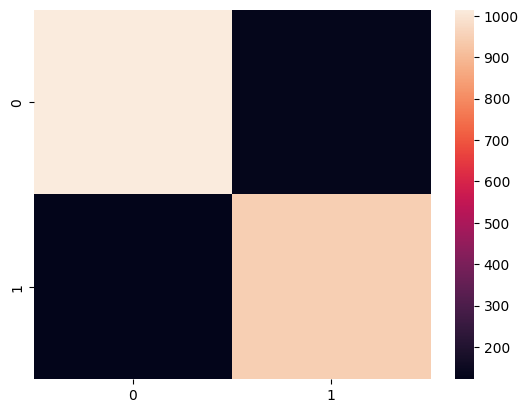

In [19]:
class_names = [0, 1]
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

In [20]:
# "check_wrong" function
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].content)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
Cảnh Sát GiựT Tiền = CSGT
Predicted: (1) --vs-- Real label: (0)
--------------------------------------------------
Quả múa chung được phết thầy ạ :v
Predicted: (1) --vs-- Real label: (0)
--------------------------------------------------
Ai giết dk con linh cá lóc tui ủng hộ 10000usd
Predicted: (1) --vs-- Real label: (0)
--------------------------------------------------
Dm vtv mặt trời ^^
Predicted: (1) --vs-- Real label: (0)
--------------------------------------------------
Quan thì ăn cái bụng to như trống. Còn người dân thì ốm yếu nuôi tụi nó
Predicted: (0) --vs-- Real label: (1)
--------------------------------------------------
Clm @@@
Predicted: (1) --vs-- Real label: (0)
--------------------------------------------------
Sam Bé Bố mày đéo có tư cách ở đây! Bố chửi thẳng cái thằng mặt lìn như mày đấy! Tay nhanh hơn não
Predicted: (1) --vs-- Real label: (0)
--------------------------------------------------
Đổi cờ hay kỳ gì cũng

In [21]:
# "infer" function
def infer(text, tokenizer, model, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Negative: {class_names[y_pred]}')

In [22]:
infer('Cảm ơn bạn đã chạy thử model của mình. Chúc một ngày tốt lành nha!', tokenizer,model)

Text: Cảm ơn bạn đã chạy thử model của mình. Chúc một ngày tốt lành nha!
Negative: 0


In [23]:
# Save model
output_path = "/content/drive/MyDrive/[AI] Ngoc Quy/Bully/bully_detection_model"
torch.save(model.state_dict(), f'{output_path}.pth')
tokenizer.save_pretrained(output_path)

('/content/drive/MyDrive/[AI] Ngoc Quy/Bully/bully_detection_model/tokenizer_config.json',
 '/content/drive/MyDrive/[AI] Ngoc Quy/Bully/bully_detection_model/special_tokens_map.json',
 '/content/drive/MyDrive/[AI] Ngoc Quy/Bully/bully_detection_model/vocab.txt',
 '/content/drive/MyDrive/[AI] Ngoc Quy/Bully/bully_detection_model/bpe.codes',
 '/content/drive/MyDrive/[AI] Ngoc Quy/Bully/bully_detection_model/added_tokens.json')